# Music Generation
- Music Generation with MusPy

In [1]:
'''
install muspy
'''
!pip install muspy

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import muspy
your_path = '~/userdata/datasets/essen_folk/' # Change it!
essen = muspy.EssenFolkSongDatabase(your_path, download_and_extract=True)

Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.


In [9]:
essen.convert()

Skip conversion as the `.muspy.success` file is found.


EssenFolkSongDatabase(root=/home/teo/userdata/datasets/essen_folk)

- You can visualize score with ``muspy.show_score()``
- You can sonify score with ``muspy.synthesize()``

- You need to install font and soundfont
    - ``muspy.download_bravura_font()``
    - ``muspy.download_musescore_soundfont()``

In [13]:
len(essen)

9034

In [14]:
a_piece = essen[0]


In [31]:
type(a_piece)

muspy.music.Music

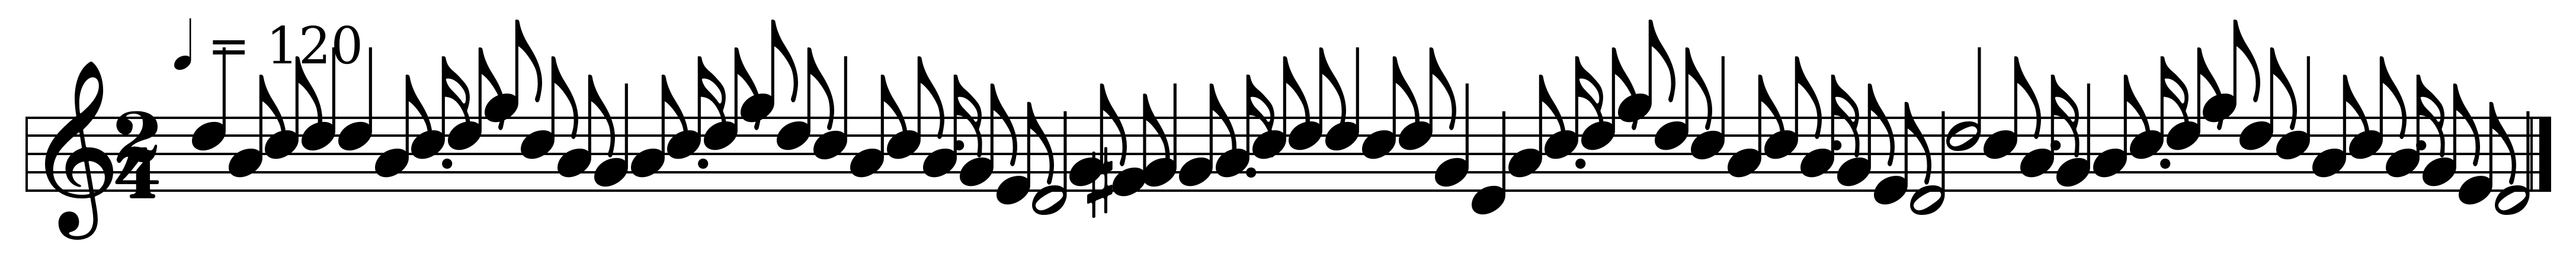

In [30]:
import matplotlib.pyplot as plt

muspy.show_score(a_piece, figsize=(30,10), font_scale=200, note_spacing=2)

In [34]:
audio = a_piece.synthesize()

In [38]:
2**16

65536

In [40]:
audio = audio / 2**15

In [42]:
audio.shape

(969920, 2)

In [43]:
import IPython.display as ipd

ipd.Audio(audio[:,0], rate=44100)

- You can convert MusPy dataset to pytorch dataset using
    - ``essen.to_pytorch_dataset(representation='note', splits=(0.6, 0.2, 0.2))``
    - this also include train/valid/test split
   


- You can convert representation by using
    - ``muspy.to_pitch_representation``
    - ``muspy.to_pianoroll_representation``
    

In [47]:
pitch_representation = a_piece.to_pitch_representation()
pitch_representation, pitch_representation.shape

(array([[74],
        [74],
        [74],
        ...,
        [62],
        [62],
        [62]]),
 (1056, 1))

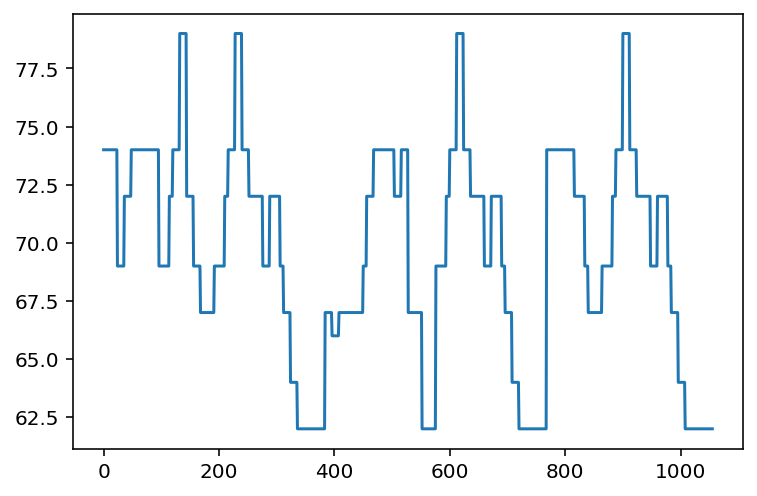

In [48]:
plt.plot(pitch_representation[:,0])

In [50]:
piano_roll = a_piece.to_pianoroll_representation()
piano_roll, piano_roll.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 (1057, 128))

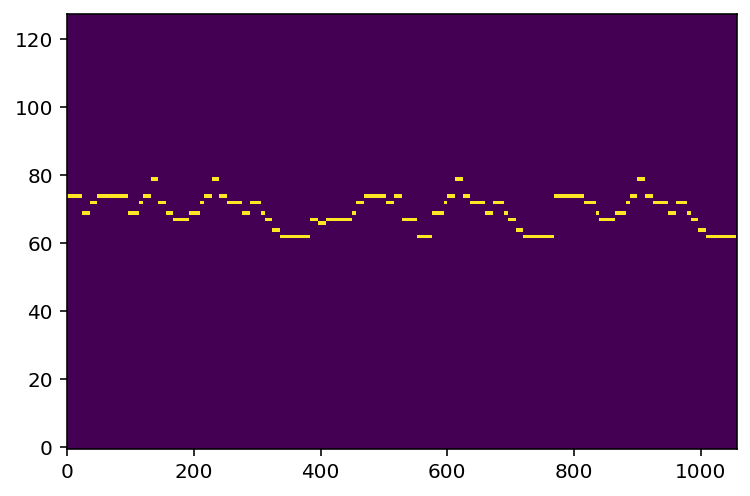

In [53]:
plt.imshow(piano_roll.T, origin='lower', aspect='auto', interpolation='nearest')

In [56]:
note_representation = a_piece.to_note_representation()
note_representation.shape, note_representation

((64, 4),
 array([[   0,   74,   24,   64],
        [  24,   69,   12,   64],
        [  36,   72,   12,   64],
        [  48,   74,   24,   64],
        [  72,   74,   24,   64],
        [  96,   69,   18,   64],
        [ 114,   72,    6,   64],
        [ 120,   74,   12,   64],
        [ 132,   79,   12,   64],
        [ 144,   72,   12,   64],
        [ 156,   69,   12,   64],
        [ 168,   67,   24,   64],
        [ 192,   69,   18,   64],
        [ 210,   72,    6,   64],
        [ 216,   74,   12,   64],
        [ 228,   79,   12,   64],
        [ 240,   74,   12,   64],
        [ 252,   72,   24,   64],
        [ 276,   69,   12,   64],
        [ 288,   72,   18,   64],
        [ 306,   69,    6,   64],
        [ 312,   67,   12,   64],
        [ 324,   64,   12,   64],
        [ 336,   62,   48,   64],
        [ 384,   67,   12,   64],
        [ 396,   66,   12,   64],
        [ 408,   67,   24,   64],
        [ 432,   67,   18,   64],
        [ 450,   69,    6,   64],
    

In [59]:
event_representation = a_piece.to_event_representation()
event_representation.shape, event_representation

((192, 1),
 array([[ 74],
        [279],
        [202],
        [ 69],
        [267],
        [197],
        [ 72],
        [267],
        [200],
        [ 74],
        [279],
        [202],
        [ 74],
        [279],
        [202],
        [ 69],
        [273],
        [197],
        [ 72],
        [261],
        [200],
        [ 74],
        [267],
        [202],
        [ 79],
        [267],
        [207],
        [ 72],
        [267],
        [200],
        [ 69],
        [267],
        [197],
        [ 67],
        [279],
        [195],
        [ 69],
        [273],
        [197],
        [ 72],
        [261],
        [200],
        [ 74],
        [267],
        [202],
        [ 79],
        [267],
        [207],
        [ 74],
        [267],
        [202],
        [ 72],
        [279],
        [200],
        [ 69],
        [267],
        [197],
        [ 72],
        [273],
        [200],
        [ 69],
        [261],
        [197],
        [ 67],
        [267],
        [195],

## Make Data Loader

In [91]:
class MelodyDataset:
  def __init__(self, muspy_dataset):
    self.dataset = muspy_dataset
    self.dataset = [x.to_note_representation() for x in self.dataset]
    
    self.idx2pitch, self.idx2dur = self._get_vocab_info()
    
    self.pitch2idx = {x:i for i, x in enumerate(self.idx2pitch)}
    self.dur2idx = {x:i for i, x in enumerate(self.idx2dur)}
    
  def _get_vocab_info(self):
    entire_pitch = []
    entire_dur = []
    for note_rep in self.dataset:
      pitch_in_piece = note_rep[:, 1]
      dur_in_piece = note_rep[:, 2]
      
      entire_pitch += pitch_in_piece.tolist()
      entire_dur += dur_in_piece.tolist()
    return list(set(entire_pitch)), list(set(entire_dur))
    
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    note_representation = self.dataset[idx]
#     note_representation = piece.to_note_representation()
    note_representation = note_representation[:,1:3].tolist()
    
    pitch = [self.pitch2idx[pitch_dur[0]] for pitch_dur in note_representation]
    dur = [self.dur2idx[pitch_dur[1]] for pitch_dur in note_representation]
    
    out_tensor = torch.LongTensor([pitch, dur]).T
    
    return out_tensor
    
train_set = MelodyDataset(essen)


In [76]:
train_set.dur2idx[12]

10

In [84]:
import torch

In [92]:
data_tensor = train_set[3]
data_tensor

tensor([[27, 14],
        [24,  5],
        [22, 10],
        [20, 10],
        [22, 10],
        [15, 10],
        [17, 16],
        [27, 14],
        [24,  5],
        [22, 10],
        [20,  5],
        [20,  5],
        [22, 10],
        [15, 10],
        [17, 16],
        [27, 14],
        [29,  5],
        [27, 10],
        [29, 10],
        [27, 10],
        [24, 10],
        [22, 16],
        [20, 10],
        [20, 16],
        [17, 10],
        [15, 10],
        [12, 10],
        [10, 16],
        [27, 10],
        [27,  5],
        [24,  5],
        [22, 10],
        [27, 10],
        [22, 16],
        [20, 10],
        [17, 10],
        [15, 10],
        [17, 10],
        [15, 10],
        [12, 10],
        [10, 26]])

## Define Model

In [99]:
import torch.nn as nn

In [97]:
num_pitch = len(train_set.idx2pitch)
num_dur = len(train_set.idx2dur)

num_pitch, num_dur

(38, 44)

In [104]:
embed_size = 8
pitch_embedder = nn.Embedding(num_pitch, embed_size)
dur_embedder = nn.Embedding(num_dur, embed_size)

In [103]:
data_tensor[:,0]

tensor([27, 24, 22, 20, 22, 15, 17, 27, 24, 22, 20, 20, 22, 15, 17, 27, 29, 27,
        29, 27, 24, 22, 20, 20, 17, 15, 12, 10, 27, 27, 24, 22, 27, 22, 20, 17,
        15, 17, 15, 12, 10])

In [105]:
pitch_embedder(data_tensor[:,0]), dur_embedder(data_tensor[:,1])

(tensor([[ 2.5640, -0.4718, -0.1267,  0.3851, -0.1213, -0.1102,  0.0039,  1.1018],
         [-0.6501,  1.3673,  0.6962, -0.2902,  1.5429,  1.4083, -0.9309, -2.0107],
         [ 1.1675, -0.5730, -2.3740, -0.5037, -0.0258,  3.3318,  0.2600,  1.0383],
         [ 0.7219, -0.5261,  1.1585,  0.7887, -0.4594,  0.2630,  0.1395,  1.5305],
         [ 1.1675, -0.5730, -2.3740, -0.5037, -0.0258,  3.3318,  0.2600,  1.0383],
         [-0.7112, -0.1844,  1.1747,  0.5358,  1.0817, -0.3889, -0.7849,  0.4715],
         [-0.0545,  1.0610, -0.3876, -1.1751,  0.6073, -0.4107,  0.5414,  1.2239],
         [ 2.5640, -0.4718, -0.1267,  0.3851, -0.1213, -0.1102,  0.0039,  1.1018],
         [-0.6501,  1.3673,  0.6962, -0.2902,  1.5429,  1.4083, -0.9309, -2.0107],
         [ 1.1675, -0.5730, -2.3740, -0.5037, -0.0258,  3.3318,  0.2600,  1.0383],
         [ 0.7219, -0.5261,  1.1585,  0.7887, -0.4594,  0.2630,  0.1395,  1.5305],
         [ 0.7219, -0.5261,  1.1585,  0.7887, -0.4594,  0.2630,  0.1395,  1.5305],
    

In [106]:
pitch_vector = pitch_embedder(data_tensor[:,0])
dur_vector = dur_embedder(data_tensor[:,1])

note_vector = torch.cat([pitch_vector, dur_vector], dim=-1)
pitch_vector.shape, dur_vector.shape, note_vector.shape

(torch.Size([41, 8]), torch.Size([41, 8]), torch.Size([41, 16]))

In [107]:
hidden_size = 8
gru_layer = nn.GRU(embed_size*2, hidden_size, batch_first=True, num_layers=2)



In [111]:
'''
nn.RNN, nn.LSTM, nn.GRU input (in default)

T (time_step) x N (num_batch) x C (num_features)

if batch_first=True
N (num_batch) x T (time_step) x C (num_features)

'''
batch = note_vector.unsqueeze(0)
out = gru_layer(batch)
batch.shape, out

(torch.Size([1, 41, 16]),
 (tensor([[[-1.2011e-01,  1.8988e-01,  1.8049e-01,  1.3278e-01,  8.1619e-02,
             3.7101e-02, -9.4541e-02, -7.0507e-02],
           [-1.5907e-03,  2.4299e-01, -4.0689e-02,  8.0569e-02,  2.4385e-01,
             1.1118e-01, -2.2786e-01, -2.6218e-01],
           [ 3.6502e-02,  2.0037e-01, -1.2579e-01,  2.3240e-02,  2.6362e-01,
             2.2427e-01, -3.3539e-01, -3.7391e-01],
           [-2.5541e-02,  2.4700e-01, -2.0787e-02,  7.0887e-02,  2.5438e-01,
             1.3659e-01, -3.1352e-01, -4.1648e-01],
           [-8.6989e-03,  2.2386e-01, -3.9163e-02,  4.2066e-02,  2.3582e-01,
             2.0138e-01, -3.3381e-01, -4.6268e-01],
           [ 5.9122e-02,  2.3460e-01, -6.1883e-02,  3.8930e-02,  2.3565e-01,
             1.6421e-01, -2.9219e-01, -5.4366e-01],
           [ 1.2499e-01,  1.8044e-01, -1.7252e-01,  2.7859e-02,  2.9310e-01,
             1.8311e-01, -3.0429e-01, -5.7941e-01],
           [ 6.8871e-02,  2.5222e-01,  3.0399e-02,  1.0118e-01,  2.3171

In [ ]:
'''
RNN family returns two outputs

hidden_state_over_entire_timestep, (last_hidden_state)

In case of nn.LSTM, last_hidden_state = (last_hidden_state, last_cell_state)
'''

In [116]:
hidden_state_over_t, last_hidden_state_old = gru_layer(batch)
hidden_state_over_t.shape, last_hidden_state_old.shape

(torch.Size([1, 41, 8]), torch.Size([2, 1, 8]))

In [123]:
total_hidden_state = torch.zeros([batch.shape[0], batch.shape[1], hidden_size])
last_hidden_state = torch.zeros_like(last_hidden_state_old)
for t in range(batch.shape[1]):
  input_of_current_t = batch[:,t:t+1]
  current_hidden_state, last_hidden_state = gru_layer(input_of_current_t, last_hidden_state)
  total_hidden_state[:,t:t+1] = current_hidden_state


In [126]:
torch.max(hidden_state_over_t-total_hidden_state)

tensor(5.9605e-08, grad_fn=<MaxBackward1>)

## Make Train Loop

## Make Inference
- 